In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score

## 1. Чтение и обработка данных

In [2]:
data = pd.read_csv('data/training.csv', index_col=0, parse_dates=['PurchDate'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72983 entries, 1 to 73014
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   IsBadBuy                           72983 non-null  int64         
 1   PurchDate                          72983 non-null  datetime64[ns]
 2   Auction                            72983 non-null  object        
 3   VehYear                            72983 non-null  int64         
 4   VehicleAge                         72983 non-null  int64         
 5   Make                               72983 non-null  object        
 6   Model                              72983 non-null  object        
 7   Trim                               70623 non-null  object        
 8   SubModel                           72975 non-null  object        
 9   Color                              72975 non-null  object        
 10  Transmission                      

## 2. Сплит по PurchDate 1/3 train, 1/3 test

In [3]:
def split_dataset(df, train_size=0.33, test_size=0.33):
    # Сортируем датафрейм по дате покупки
    df_sorted = df.sort_values(by='PurchDate')
    
    # Вычисляем границы для разделения
    n = len(df_sorted)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + test_size))
    
    # Разделяем датафрейм по датам
    train_df = df_sorted.iloc[:train_end]
    val_df = df_sorted.iloc[train_end:val_end]
    test_df = df_sorted.iloc[val_end:]

    print(f"Train max date: {train_df['PurchDate'].max()}")
    print(f"Validation max date: {val_df['PurchDate'].max()}")
    print(f"Test max date: {test_df['PurchDate'].max()}")
    
    # Разделяем признаки и целевой признак
    X_train = train_df.drop(columns=['IsBadBuy', 'PurchDate'])
    y_train = train_df['IsBadBuy']
    
    X_val = val_df.drop(columns=['IsBadBuy', 'PurchDate'])
    y_val = val_df['IsBadBuy']
    
    X_test = test_df.drop(columns=['IsBadBuy', 'PurchDate'])
    y_test = test_df['IsBadBuy']
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
X_train, X_valid, X_test, y_train, y_valid, y_test = split_dataset(data)

Train max date: 2009-09-11 00:00:00
Validation max date: 2010-05-11 00:00:00
Test max date: 2010-12-30 00:00:00


In [5]:
print(f"Train size: {X_train.shape}, {y_train.shape}")
print(f"Validation size: {X_valid.shape}, {y_valid.shape}")
print(f"Test size: {X_test.shape}, {y_test.shape}")

Train size: (24084, 31), (24084,)
Validation size: (24084, 31), (24084,)
Test size: (24815, 31), (24815,)


## 3. Обработка признаков

In [6]:
# Список числовых и категориальных признаков 
cat_cols = X_train.select_dtypes(include=['object']).columns.to_list()
num_cols = X_train.select_dtypes(include=['number']).columns.to_list()

In [7]:
# 1. Кастомный трансформер для заполнения пропусков, сохраняющий DataFrame
class DataFrameImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols, num_cols):
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
        self.num_imputer = KNNImputer(n_neighbors=2, weights='uniform')
    
    def fit(self, X, y=None):
        self.cat_imputer.fit(X[self.cat_cols])
        self.num_imputer.fit(X[self.num_cols])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.cat_cols] = self.cat_imputer.transform(X_copy[self.cat_cols])
        X_copy[self.num_cols] = self.num_imputer.transform(X_copy[self.num_cols])
        return X_copy

In [8]:
# 2. Кастомный трансформер для кодирования и нормализации, сохраняющий DataFrame
class DataFrameEncoderScaler(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols, num_cols):
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.scaler = MinMaxScaler()
    
    def fit(self, X, y=None):
        # Обучаем кодировщик и скалер
        self.encoder.fit(X[self.cat_cols])
        self.scaler.fit(X[self.num_cols])
        
        # Сохраняем имена признаков после преобразования
        cat_feature_names = self.encoder.get_feature_names_out(self.cat_cols)
        num_feature_names = self.num_cols
        
        self._feature_names_out = list(cat_feature_names) + list(num_feature_names)
        
        return self
    
    def transform(self, X):
        X_cat = self.encoder.transform(X[self.cat_cols])
        X_num = self.scaler.transform(X[self.num_cols])
        
        # Собираем обратно в DataFrame с новыми именами столбцов
        cat_feature_names = self.encoder.get_feature_names_out(self.cat_cols)
        num_feature_names = self.num_cols
        
        X_transformed = pd.DataFrame(
            np.hstack([X_cat, X_num]),
            columns=list(cat_feature_names) + list(num_feature_names),
            index=X.index
        )
        return X_transformed
    
    def get_feature_names_out(self, input_features=None):
        if not hasattr(self, '_feature_names_out'):
            raise ValueError("Метод fit() не был вызван.")
        return np.array(self._feature_names_out)

In [9]:
# 3. Создаем pipeline
pipeline = Pipeline([
    ('fill_na', DataFrameImputer(cat_cols, num_cols)),
    ('encode_scale', DataFrameEncoderScaler(cat_cols, num_cols))
])

X_train_transformed = pipeline.fit_transform(X_train, y_train)
X_valid_transformed = pipeline.transform(X_valid)

## 4. Gini_score

In [10]:
def gini_score(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    gini = 2 * auc - 1
    return gini

## 5. SKlearn - LogisticRegression, GaussianNB, KNeighborsClassifier

In [11]:
def evaluate_models(X_train, y_train, X_valid, y_valid):

    lg = LogisticRegression(max_iter=1000, random_state=21)
    gnb = GaussianNB()
    knn = KNeighborsClassifier()

    models = [lg, gnb, knn]

    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        y_pred_proba = model.predict_proba(X_valid)[:, 1]
        
        # Вывод
        print(f"\n{model.__class__.__name__}:")
        print(classification_report(y_valid, y_pred, zero_division=0))
        print(f"Gini: {gini_score(y_valid, y_pred_proba):.4f}\n")
        print("="*30)

In [12]:
evaluate_models(X_train_transformed, y_train, X_valid_transformed, y_valid)


LogisticRegression:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     20926
           1       0.63      0.23      0.34      3158

    accuracy                           0.88     24084
   macro avg       0.76      0.61      0.64     24084
weighted avg       0.86      0.88      0.86     24084

Gini: 0.4515


GaussianNB:
              precision    recall  f1-score   support

           0       0.88      0.46      0.61     20926
           1       0.14      0.59      0.23      3158

    accuracy                           0.48     24084
   macro avg       0.51      0.53      0.42     24084
weighted avg       0.79      0.48      0.56     24084

Gini: 0.0556


KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     20926
           1       0.52      0.07      0.12      3158

    accuracy                           0.87     24084
   macro avg       0.70      0.53      0.53

## 6. Собственная имплементация - LogisticRegression, GaussianNB, KNeighborsClassifier

In [13]:
def evaluate_my_model(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    
    # Вывод
    print(f"\n{model.__class__.__name__}:")
    print(classification_report(y_valid, y_pred, zero_division=0))
    print(f"Gini: {gini_score(y_valid, y_pred_proba):.4f}\n")
    print("="*30)

#### 6.1 My LogisticRegression

In [14]:
class my_log_reg:
    def __init__(self, learning_rate=0.01, n_iterations=1000, random_state=None, tol=1e-4):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.random_state = random_state
        self.rng = np.random.default_rng(random_state)
        self.tol = tol  # Параметр толерантности
        self.loss_history = []  # Для отслеживания истории потерь

    def _sigmoid(self, z):
        # Векторная реализация сигмоиды
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # Защита от overflow

    def _loss(self, y_true, y_pred):
        # Функция потерь (log loss) — векторная
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape

        # Инициализация параметров
        self.weights = np.zeros(n_features)
        self.bias = 0.0

        indices = np.arange(n_samples)
        prev_loss = float('inf')

        for iteration in range(self.n_iterations):
            # Перемешиваем индексы для SGD
            self.rng.shuffle(indices)

            # Стохастический шаг: по одному объекту
            for idx in indices: 
                x_i = X[idx]
                y_i = y[idx]

                # Линейная модель и предсказание
                z = np.dot(x_i, self.weights) + self.bias
                y_pred = self._sigmoid(z)

                # Градиенты
                dw = (y_pred - y_i) * x_i
                db = (y_pred - y_i)

                # Обновление параметров
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

            # Вычисление потерь по всей выборке
            y_pred_full = self.predict_proba(X)[:, 1]
            current_loss = self._loss(y, y_pred_full)
            self.loss_history.append(current_loss)

            # Проверка сходимости
            if np.abs(prev_loss - current_loss) < self.tol:
                print(f"Сходимость достигнута на итерации {iteration}")
                break
            prev_loss = current_loss

    def predict_proba(self, X):
        # Векторное предсказание вероятностей
        z = np.dot(X, self.weights) + self.bias  # shape: (n_samples,)
        prob_1 = self._sigmoid(z)  # Вероятность класса 1
        prob_0 = 1 - prob_1         # Вероятность класса 0
        return np.column_stack((prob_0, prob_1))  # shape: (n_samples, 2)

    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs[:, 1] >= threshold).astype(int)

In [15]:
my_lg = my_log_reg(random_state=21)
evaluate_my_model(my_lg, X_train_transformed, y_train, X_valid_transformed, y_valid)

Сходимость достигнута на итерации 5

my_log_reg:
              precision    recall  f1-score   support

           0       0.89      0.98      0.94     20926
           1       0.64      0.22      0.32      3158

    accuracy                           0.88     24084
   macro avg       0.77      0.60      0.63     24084
weighted avg       0.86      0.88      0.85     24084

Gini: 0.4700



#### 6.2 My GaussianNB

In [16]:
class my_gaussianNB:
    def __init__(self, var_smoothing=1e-15):
        self.class_probs = {}  # Априорные вероятности классов
        self.class_means = {}  # Средние значения признаков для каждого класса
        self.class_std = {}  # Стандартные отклонения признаков для каждого класса
        self.classes = None  # Уникальные классы в обучающей выборке
        self.var_smoothing = var_smoothing #сглаживание

    def fit(self, X, y):
        # Убедимся, что y — одномерный массив
        X = np.array(X)
        y = np.array(y)
        
        self.classes = np.unique(y)
        
        # Проверяем, что задача бинарная
        if len(self.classes) != 2:
            raise ValueError("This implementation supports only binary classification (2 classes).")
        
        n_samples = X.shape[0]

        for cls in self.classes:
            X_class = X[y == cls]  # Отбираем объекты данного класса
            self.class_probs[cls] = X_class.shape[0] / n_samples  # Вероятность класса
            self.class_means[cls] = X_class.mean(axis=0)  # Средние значения признаков
            self.class_std[cls] = X_class.std(axis=0)  # Стандартные отклонения

    def _gauss_pdf(self, X, mean, std):
        std = np.clip(std, 1e-15, 1e15)# ограничиваем слишком большие и малые значения (защита деления на 0) 
        exponent = -0.5 * ((X - mean) / std) ** 2 #вычисляем показатель степени в формуле плотности нормального распределения
        exponent = np.clip(exponent, -100, None)# чтобы np.exp(exponent) не стало 0
        pdf = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(exponent)# считаем плотность
        return np.maximum(pdf, self.var_smoothing)  #замена очень маленьких значений (защита от log(0)= бесконечность),

    def predict_proba(self, X):
        X = np.array(X)
        log_probs = []
        for cls in self.classes:
            pdf = self._gauss_pdf(X, self.class_means[cls], self.class_std[cls])
            log_prob = (np.log(self.class_probs[cls]) + np.sum(np.log(pdf), axis=1))  # теперь pdf ≥ var_smoothing
            log_probs.append(log_prob)
        log_probs = np.stack(log_probs, axis=1)
        exp_logits = np.exp(log_probs - np.max(log_probs, axis=1, keepdims=True))
        probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return probs

    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs[:, 1] >= threshold).astype(int)



In [17]:
my_gnb = my_gaussianNB()
evaluate_my_model(my_gnb, X_train_transformed, y_train, X_valid_transformed, y_valid)


my_gaussianNB:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20926
           1       0.13      1.00      0.23      3158

    accuracy                           0.13     24084
   macro avg       0.07      0.50      0.12     24084
weighted avg       0.02      0.13      0.03     24084

Gini: 0.0000



#### 6.4 My KNN classifier

In [18]:
class my_knn_classifier:
    def __init__(self, n_neighbors=5):
        if n_neighbors < 1:
            raise ValueError("n_neighbors должно быть ≥ 1")
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        # Валидация меток
        if not np.all(np.isin(y, [0, 1])):
            raise ValueError("y должен содержать только 0 и 1 (бинарная классификация)")
        
        if X.shape[0] != y.shape[0]:
            raise ValueError("Число строк X и y должно совпадать")
        
        self.X_train = X
        self.y_train = y

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict_proba(self, X):
        X = np.array(X)
        
        if self.X_train is None:
            raise ValueError("Модель не обучена. Вызовите fit() сначала.")
            
        if X.shape[1] != self.X_train.shape[1]:
            raise ValueError(
                f"Число признаков в X ({X.shape[1]}) не совпадает с обучающими ({self.X_train.shape[1]})"
            )
        
        probabilities = []
        for x in X:
            # Вычислить расстояния до всех обучающих объектов
            distances = np.array([
                self._euclidean_distance(x, x_train) 
                for x_train in self.X_train
            ])
            
            # Индексы k ближайших соседей
            k_indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_labels = self.y_train[k_indices]
            
            # Вероятность класса 1 = доля единиц среди k соседей
            prob_1 = np.mean(k_nearest_labels)
            prob_0 = 1 - prob_1  # Вероятность класса 0
            probabilities.append([prob_0, prob_1])
        
        return np.array(probabilities)

    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs[:, 1] >= threshold).astype(int)

In [19]:
my_knn = my_knn_classifier()

# Берем первые 1000 примеров
n = 1000

X_train_subset = X_train_transformed[:n]
X_val_subset = X_valid_transformed[:n]
y_train_subset = y_train[:n]
y_val_subset = y_valid[:n]

evaluate_my_model(my_knn, X_train_subset, y_train_subset, X_val_subset, y_val_subset)


my_knn_classifier:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       877
           1       0.27      0.03      0.06       123

    accuracy                           0.87      1000
   macro avg       0.57      0.51      0.49      1000
weighted avg       0.80      0.87      0.82      1000

Gini: 0.1169



## 7. Новые нелинейные признаки

In [20]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.group_means = None  # Для хранения средних по группам
    
    def fit(self, X, y=None):
        # Вычисляем средние значения continuous_feature по categorical_feature
        if 'WheelType' in X.columns and 'VehBCost' in X.columns:
            self.group_means = X.groupby('WheelType')['VehBCost'].mean()
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # 1. Новый числовой признак: отношение двух числовых столбцов
        if 'VehBCost' in X_copy.columns and \
           'MMRCurrentAuctionAveragePrice' in X_copy.columns:
            X_copy['cost_vs_mmr'] = X_copy['VehBCost'] / X_copy['MMRCurrentAuctionAveragePrice']
        
        # 2. Новый числовой признак: среднее значение VehBCost по Make
        if self.group_means is not None:
            X_copy['wheeltype_vehbcost_mean'] = X_copy['WheelType'].map(self.group_means)

        # 3. Новые сезонные признаки 
        if 'PurchDate' in X_copy.columns:
            X_copy['PurchYear'] = X_copy['PurchDate'].dt.year
            X_copy['PurchMonth'] = X_copy['PurchDate'].dt.month
            X_copy['PurchDayOfYear'] = X_copy['PurchDate'].dt.dayofyear
            X_copy['IsPurchInWinter'] = X_copy['PurchMonth'].isin([12, 1, 2]).astype(int)
        
        return X_copy

In [21]:
pipeline = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('fill_na', DataFrameImputer(cat_cols, num_cols)),
    ('encode_scale', DataFrameEncoderScaler(cat_cols, num_cols))
])

X_train_transformed = pipeline.fit_transform(X_train, y_train)
X_valid_transformed = pipeline.transform(X_valid)

evaluate_models(X_train_transformed, y_train, X_valid_transformed, y_valid)


LogisticRegression:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     20926
           1       0.63      0.23      0.34      3158

    accuracy                           0.88     24084
   macro avg       0.76      0.61      0.64     24084
weighted avg       0.86      0.88      0.86     24084

Gini: 0.4515


GaussianNB:
              precision    recall  f1-score   support

           0       0.88      0.46      0.61     20926
           1       0.14      0.59      0.23      3158

    accuracy                           0.48     24084
   macro avg       0.51      0.53      0.42     24084
weighted avg       0.79      0.48      0.56     24084

Gini: 0.0556


KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     20926
           1       0.52      0.07      0.12      3158

    accuracy                           0.87     24084
   macro avg       0.70      0.53      0.53

## 8. Сокращение размерности

In [22]:
pipeline = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('fill_na', DataFrameImputer(cat_cols, num_cols)),
    ('encode_scale', DataFrameEncoderScaler(cat_cols, num_cols)),
    ('feature_selection', SelectFromModel(
        estimator=LogisticRegression(
            C=0.1,
            class_weight='balanced',
            max_iter=2000,
            penalty='l1',
            solver='liblinear',
            random_state=21),
        max_features=10)
    )
])

X_train_transformed = pipeline.fit_transform(X_train, y_train)
X_valid_transformed = pipeline.transform(X_valid)
evaluate_models(X_train_transformed, y_train, X_valid_transformed, y_valid)


LogisticRegression:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     20926
           1       0.60      0.23      0.33      3158

    accuracy                           0.88     24084
   macro avg       0.75      0.60      0.63     24084
weighted avg       0.85      0.88      0.85     24084

Gini: 0.4673


GaussianNB:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     20926
           1       0.45      0.31      0.36      3158

    accuracy                           0.86     24084
   macro avg       0.67      0.62      0.64     24084
weighted avg       0.84      0.86      0.85     24084

Gini: 0.4495


KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     20926
           1       0.57      0.24      0.34      3158

    accuracy                           0.88     24084
   macro avg       0.73      0.61      0.63

In [23]:
selector = pipeline.named_steps['feature_selection']
estimator = selector.estimator_

# Берём абсолютные значения коэффициентов
coefs = np.abs(estimator.coef_[0])

# Получаем имена признаков ПОСЛЕ всех преобразований
preprocessor = pipeline.named_steps['encode_scale']
feature_names = preprocessor.get_feature_names_out()

# Проверяем длины
assert len(coefs) == len(feature_names), \
    f"Длины не совпадают: {len(coefs)} коэффициентов, {len(feature_names)} имён"

# Создаём таблицу важности
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Abs_coef': coefs
}).sort_values('Abs_coef', ascending=False)

# Вывод топ признаков
print(feature_importance.head(10))

                         Feature  Abs_coef
1641           WheelType_missing  3.160344
1695                     VehYear  1.896040
1698                      VehOdo  1.166643
1707                       BYRNO  0.795423
1711                WarrantyCost  0.757023
1709                    VehBCost  0.735628
373   Model_GRAND PRIX 3.8L V6 S  0.597016
400     Model_IMPALA 3.5L V6 SFI  0.585688
836                     Trim_150  0.520932
1693                     VNST_VA  0.504654


## 9. Подбор параметров и модели

In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
gini_scorer = make_scorer(gini_score, needs_proba=True)

In [25]:
# 1. Обновляем конвейер
pipeline = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('fill_na', DataFrameImputer(cat_cols, num_cols)),
    ('encode_scale', DataFrameEncoderScaler(cat_cols, num_cols)),
    ('feature_selection', SelectFromModel(estimator=LogisticRegression(
        C=0.1,
        class_weight='balanced',
        max_iter=2000,
        penalty='l1',
        solver='liblinear',
        random_state=21
        ),
        max_features=100)),
    ('classifier', LogisticRegression(
        max_iter=2000,
        penalty='l1',
        solver='liblinear',
        random_state=21))  # имя шага — 'classifier'
])

# 2. Формируем параметрическую сетку: для каждой модели

param_grid = [
    {
        'classifier__C': [0.01, 0.1, 1, 5],
        'classifier__class_weight': ['balanced', None]
    }
]

# 3. Настраиваем GridSearchCV
gr_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=gini_scorer,
    cv=skf,
    n_jobs=-1,
    verbose=1
)

# 4. Обучаем
gr_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/poseluevalexandr/school21/chardnea/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=21, shuffle=True),
             estimator=Pipeline(steps=[('feature_engineering',
                                        FeatureEngineeringTransformer()),
                                       ('fill_na',
                                        DataFrameImputer(cat_cols=['Auction',
                                                                   'Make',
                                                                   'Model',
                                                                   'Trim',
                                                                   'SubModel',
                                                                   'Color',
                                                                   'Transmission',
                                                                   'WheelType',
                                                                   'Nationality',
                                                                   'Size',
                                                                   'TopThreeAmericanName',
                                                                   'PRIMEUNIT',
                                                                   'AUCGUART',
                                                                   'VNST'],
                                                         num_...
                                                                                     class_weight='balanced',
                                                                                     max_iter=2000,
                                                                                     penalty='l1',
                                                                                     random_state=21,
                                                                                     solver='liblinear'),
                                                        max_features=100)),
                                       ('classifier',
                                        LogisticRegression(max_iter=2000,
                                                           penalty='l1',
                                                           random_state=21,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid=[{'classifier__C': [0.01, 0.1, 1, 5],
                          'classifier__class_weight': ['balanced', None]}],
             scoring=make_scorer(gini_score, needs_proba=True), verbose=1)

## 10. Gini на валидации и тесте

In [26]:
# 2. Получаем топ‑5 лучших параметров по CV
sorted_indices = np.argsort(gr_search.cv_results_['mean_test_score'])[::-1]
top_params = [gr_search.cv_results_['params'][i] for i in sorted_indices[:5]]
candidate_params = [gr_search.best_params_] + top_params

final_best_score = -np.inf
final_best_params = None

# 3. Цикл по кандидатам
for params in candidate_params:
    try:
        # Устанавливаем параметры
        pipeline.set_params(**params)
        
        # Обучаем на тренировочных данных
        pipeline.fit(X_train, y_train)
        
        # Оцениваем на валидации
        valid_score = gini_scorer(pipeline, X_valid, y_valid)
        
        # Обновляем лучший результат
        if valid_score > final_best_score:
            final_best_score = valid_score
            final_best_params = params
            
    except Exception as e:
        print(f"Пропущен набор параметров {params} из‑за ошибки: {e}")

# 3. Итоги
print("Финальные лучшие параметры:", final_best_params)
print(f"Gini на X_valid: {round(final_best_score,4)}")

Финальные лучшие параметры: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced'}
Gini на X_valid: 0.4738


In [27]:
pipeline.set_params(**final_best_params)
pipeline.fit(X_train, y_train)

train_gini = gini_scorer(pipeline, X_train, y_train)
print(f"Gini на трейне: {round(train_gini,4)}")

test_gini = gini_scorer(pipeline, X_test, y_test)
print(f"Gini на тесте: {round(test_gini,4)}")

gini_diff = train_gini - test_gini
if gini_diff > 0.1:
    print("Возможное переобучение!")
elif gini_diff < -0.05:
    print("Возможное недообучение!")
else:
    print("Сбалансированное качество")

Gini на трейне: 0.5409
Gini на тесте: 0.5014
Сбалансированное качество


## 11. Имплементация Recall, Precision, F1 score and AUC PR metrics

In [28]:
def my_confusion_matrix(y_true, y_pred):
    """Вычисляет TP, FP, FN, TN для бинарной классификации."""
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    return TP, FP, FN, TN

def my_precision(y_true, y_pred):
    TP, FP, FN, TN = my_confusion_matrix(y_true, y_pred)
    if TP + FP == 0:
        return 0.0  # избегаем деления на 0
    return TP / (TP + FP)

def my_recall(y_true, y_pred):
    TP, FP, FN, TN = my_confusion_matrix(y_true, y_pred)
    if TP + FN == 0:
        return 0.0
    return TP / (TP + FN)

def my_f1(y_true, y_pred):
    precision, recall = my_precision(y_true, y_pred), my_recall(y_true, y_pred)
    return 0.0 if precision + recall == 0 else 2 * (precision * recall) / (precision + recall)

In [29]:
def my_auc_pr(y_true, y_prob):
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    
    # Если нет положительных примеров — AUC = 0
    if np.sum(y_true) == 0:
        return 0.0, [], []
    
    # 1. Сортируем объекты по убыванию предсказанных вероятностей
    sorted_idx = np.argsort(y_prob)[::-1]
    y_true_sorted = y_true[sorted_idx]
    
    # 2. Считаем TP и FP на каждом пороге
    TP = 0  # True Positives (верно угадали «1»)
    FP = 0  # False Positives (ошибочно назвали «1» то, что «0»)
    precision_list = []
    recall_list = []
    
    total_positives = np.sum(y_true)  # Всего настоящих «1» в данных
    
    for label in y_true_sorted:
        if label == 1:
            TP += 1  # Угадали «1»
        else:
            FP += 1  # Ошибочно назвали «1» объект класса «0»
        
        # Считаем precision и recall для текущего порога
        if TP + FP == 0:
            precision = 0  # Избегаем деления на 0
        else:
            precision = TP / (TP + FP)
        
        recall = TP / total_positives
        
        precision_list.append(precision)
        recall_list.append(recall)
    
    # 3. «Сглаживаем» precision: она не должна расти при уменьшении recall
    # Проходим справа налево (от большого recall к маленькому)
    # и запоминаем лучшую (максимальную) precision
    best_precision = 0
    for i in range(len(precision_list) - 1, -1, -1):
        if precision_list[i] > best_precision:
            best_precision = precision_list[i]
        else:
            precision_list[i] = best_precision
    
    # 4. Считаем площадь под кривой (AUC)
    auc = np.trapz(precision_list, recall_list)
    
    return max(0.0, auc), np.array(precision_list), np.array(recall_list)


In [30]:
y_proba = pipeline.predict_proba(X_test)[:, 1]

sk_auc_pr = average_precision_score(y_test, y_proba)
my_auc_pr, my_precision, my_recall = my_auc_pr(y_test, y_proba)
sk_auc_pr, my_auc_pr

(0.45266829630197125, 0.45307270319942483)

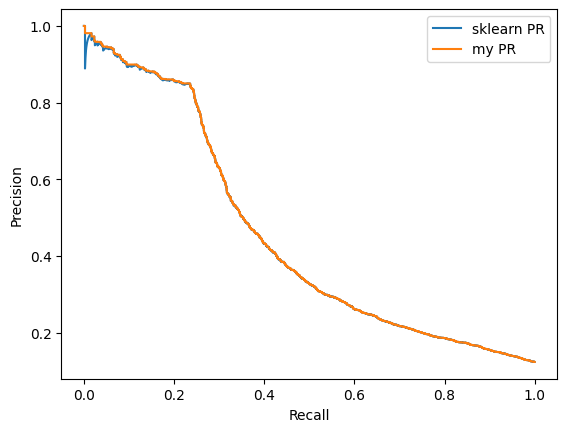

In [31]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(recall, precision, label="sklearn PR")
plt.plot(my_recall, my_precision, label="my PR")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()


## 12. Какой метрический показатель вы предпочитаете использовать для выявления «лимонных» автомобилей?
«Лимонный» авто - это машина со скрытыми дефектами, которые проявляются после покупки.
Основные метрики:
- precision - покажет какая доля предсказанных «лимонов» действительно являются лимонами
- recall - покажет какую долю реальных «лимонов» модель нашла
- F1‑score - для баланса precision и recall.
- AUC‑PR - когда класс «лимоны» редкий (дисбаланс), AUC‑PR более информативен.

И с помощью выбора threshold (больше - меньше) макзимизировать ту или иную метрику в зависимости от бизнесзадачи.

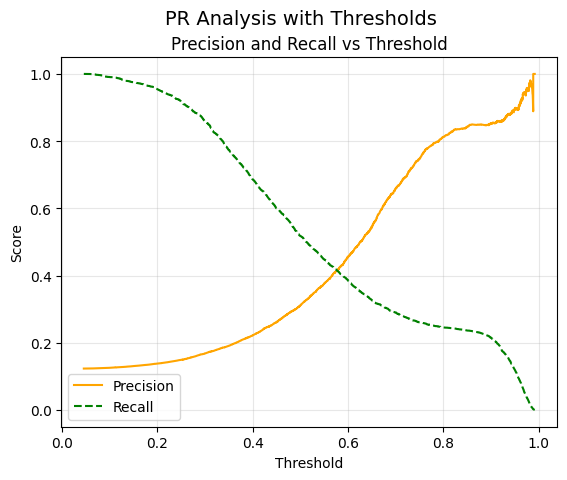

In [32]:
plt.plot(thresholds, precision[:-1], label="Precision", color="orange", linestyle="-")
plt.plot(thresholds, recall[:-1], label="Recall", color="green", linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.grid(True, alpha=0.3)
plt.legend()


# Общий заголовок
plt.suptitle("PR Analysis with Thresholds", fontsize=14)
plt.show()
